# Flower recognition using CNN


## TODo

1. pick a dataset
2. Download the dataset
3. Import the dataset using pytorch
4. Explore the dataset
5. prepare the dataset for training
6. save the model architecture


## download the Dataset
using `opendatasets` and download the dataset from https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [3]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: errtika
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:01<00:00, 172MB/s]


##import the dataset into pytorch

use the `ImageFolder` class from `torchvision`

In [87]:
data_dir = './flowers-recognition/flowers'

In [88]:
os.listdir(data_dir)

['sunflower', 'tulip', 'daisy', 'rose', 'dandelion']

In [89]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
tulip : 984
daisy : 764
rose : 784
dandelion : 1052


In [90]:
dataset = ImageFolder(data_dir)

In [91]:
len(dataset)

4317

In [92]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [93]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [94]:
dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64),
                                           tt.RandomCrop(64),
                                           tt.ToTensor()]))

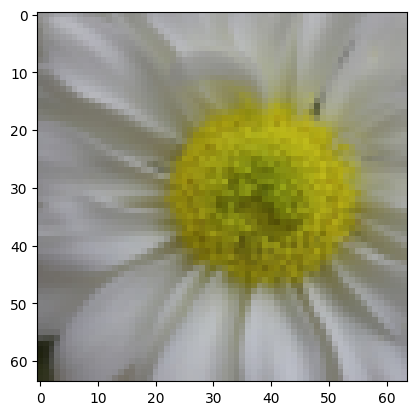

In [95]:
img, label = dataset[0];
img.shape
##need to permute for matplotlib
plt.imshow(img.permute(1,2,0))

In [96]:
#validation and train set sizes
val_pct=0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [97]:
#spliting the dataset
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [98]:
#creating dataloaders of batches of size 128
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)


batch_size = 128
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
val_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [99]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
        print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


torch.Size([128, 3, 64, 64])


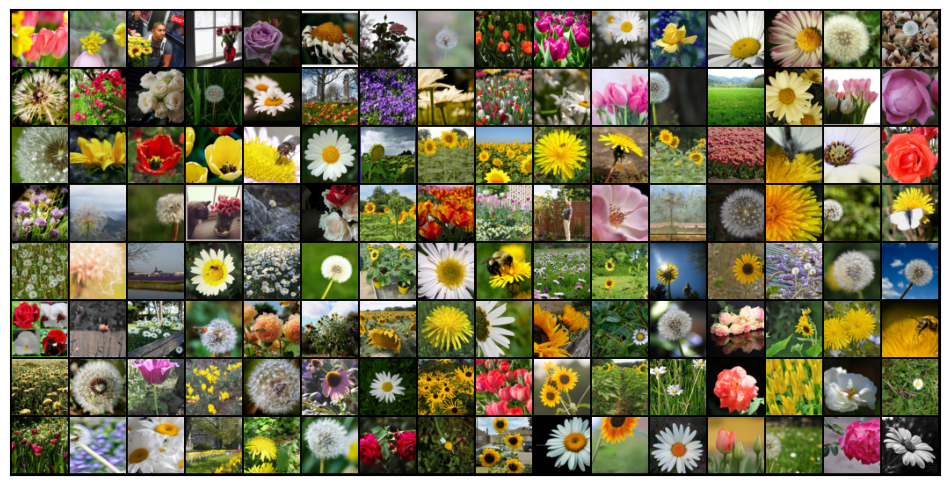

In [100]:
show_batch(train_dl)

### Utiity functions and classes / GPU utilities


In [101]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [102]:
torch.cuda.is_available()

True

In [103]:
device = get_default_device()

In [104]:
device

device(type='cuda')

In [105]:
img, label = dataset[0]

In [106]:
img.shape

torch.Size([3, 64, 64])

In [107]:
img.device

device(type='cpu')

In [108]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [109]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

### Model training utilities


In [110]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [111]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Model

In [112]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # input 128 -> 3 x 64 x64
        self.conv1 = conv_block(in_channels, 64)
        # input 128 -> 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True)
        # input 128 -> 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))


        self.conv3 = conv_block(128, 256, pool=True)
        # input 128 -> 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True)
        # input 128 -> 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 -> 512 x 1 x 1
                                        ## converts any input to required size
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [113]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training

In [114]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6084156036376953, 'val_acc': 0.22789227962493896}]

In [115]:
history += fit(10, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3770, val_loss: 1.6387, val_acc: 0.3750
Epoch [1], train_loss: 0.9005, val_loss: 0.9653, val_acc: 0.5965
Epoch [2], train_loss: 0.8322, val_loss: 0.7370, val_acc: 0.7378
Epoch [3], train_loss: 0.7600, val_loss: 0.9380, val_acc: 0.6569
Epoch [4], train_loss: 0.7480, val_loss: 0.9595, val_acc: 0.6379
Epoch [5], train_loss: 0.6220, val_loss: 0.7343, val_acc: 0.7353
Epoch [6], train_loss: 0.6053, val_loss: 1.1876, val_acc: 0.6705
Epoch [7], train_loss: 0.5614, val_loss: 1.1225, val_acc: 0.6599
Epoch [8], train_loss: 0.5000, val_loss: 0.6628, val_acc: 0.7694
Epoch [9], train_loss: 0.4986, val_loss: 0.9553, val_acc: 0.6727


In [116]:
history += fit(10, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3928, val_loss: 0.5006, val_acc: 0.8202
Epoch [1], train_loss: 0.3249, val_loss: 0.4850, val_acc: 0.8241
Epoch [2], train_loss: 0.2944, val_loss: 0.5497, val_acc: 0.8250
Epoch [3], train_loss: 0.2720, val_loss: 0.5165, val_acc: 0.8275
Epoch [4], train_loss: 0.2609, val_loss: 0.5477, val_acc: 0.8289
Epoch [5], train_loss: 0.2414, val_loss: 0.5207, val_acc: 0.8392
Epoch [6], train_loss: 0.2257, val_loss: 0.5287, val_acc: 0.8149
Epoch [7], train_loss: 0.2131, val_loss: 0.5096, val_acc: 0.8353
Epoch [8], train_loss: 0.1736, val_loss: 0.5228, val_acc: 0.8207
Epoch [9], train_loss: 0.1765, val_loss: 0.5641, val_acc: 0.8207


In [117]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

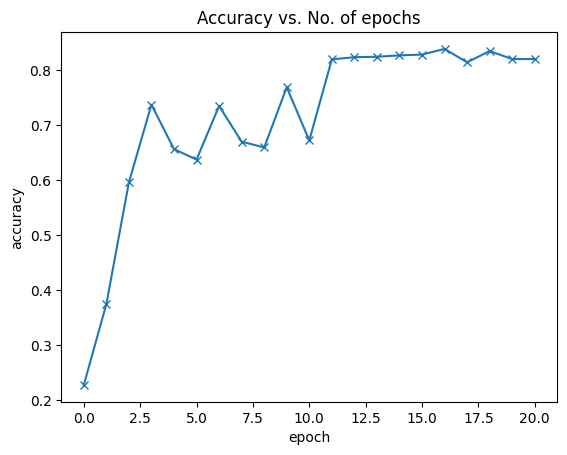

In [118]:
plot_accuracies(history)

In [119]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-gx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

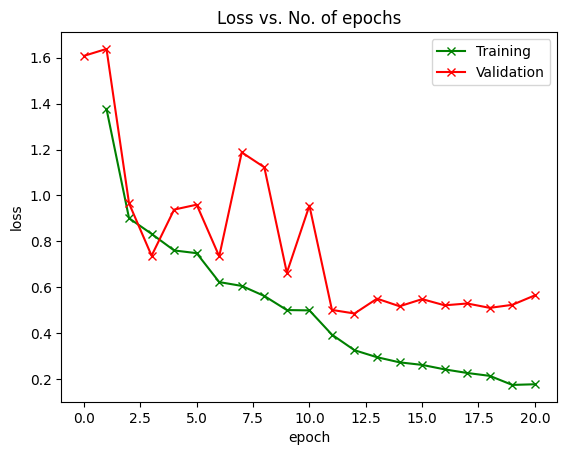

In [120]:
plot_losses(history)

### Test with invidual images

In [121]:
def predict_image(img, model, classes):
    # Convert to a batch of 1 cause our model works with batches
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Testing on random images from internet

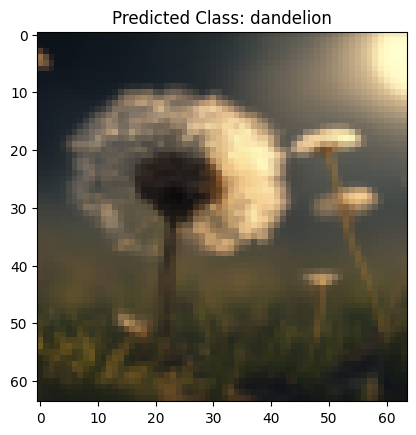

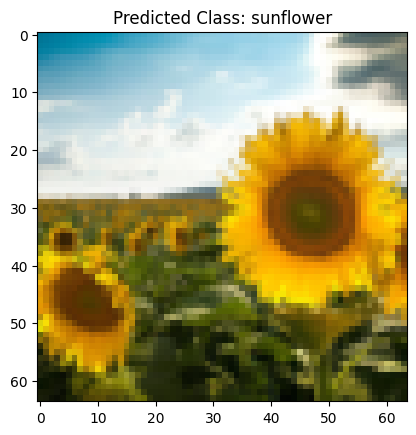

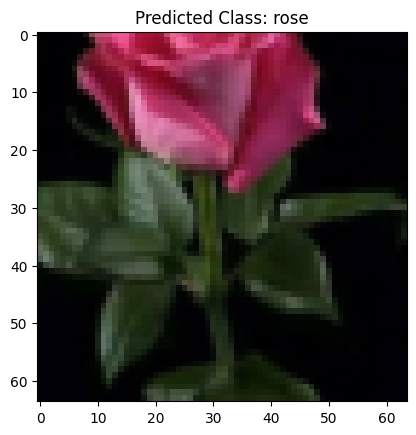

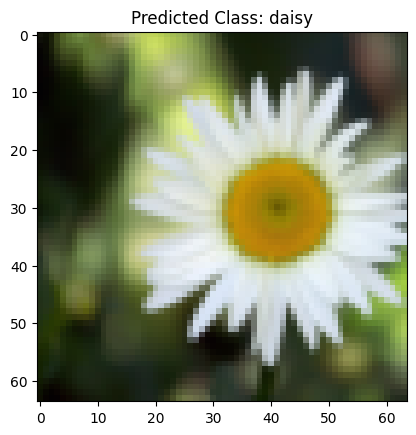

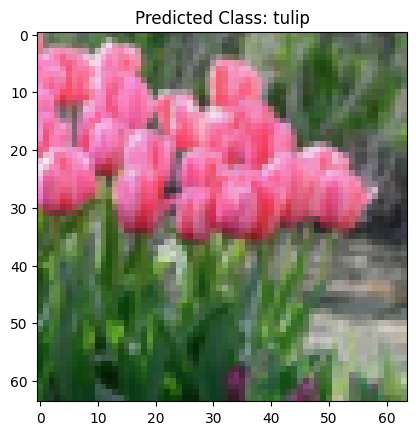

In [167]:
##########################for manually uploaded image####################
from PIL import Image

paths = [
         '/content/test/dandlion2.jpg',
         '/content/test/sunflower.jpg',
         '/content/test/rose.jpg',
         '/content/test/daisy.jpg',
         '/content/test/tulip.jpeg']

for path in paths:
    transform = tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()])
    image = Image.open(path)
    image = transform(image)

    # Assuming 'predict_image' is your function for making predictions
    predicted_class = predict_image(image, model, dataset.classes)

    # Display the image with the predicted class
    plt.imshow(image.permute((1, 2, 0)))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()


In [123]:
## predicting and showing
def show_image_pred(valid_ds, ind):
    img, label = valid_ds[ind]
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target: ', dataset.classes[label])
    print('Prediction: ', pred)

Label: dandelion (1)
Predicted:  sunflower


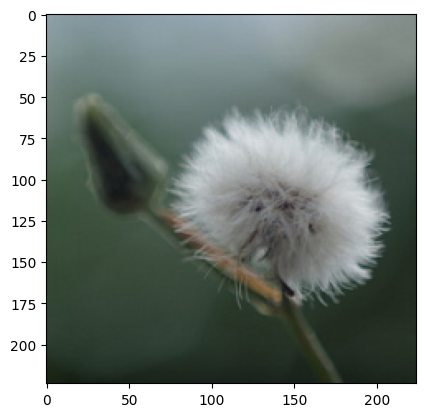

In [169]:
img, label = valid_ds[179]
show_image(img,label)
pred = predict_image(img, model, dataset.classes)
print('Predicted: ', pred)